Создание модели


In [1]:
#Импортируем нужные библиотеки и модули.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve

Загружаем наши датасеты

In [2]:
data = pd.read_csv('datasets/data.csv')

Обрабатываем наши данные

In [3]:
# Заполнение пропущенных значений нулями
data = data.fillna(0)

# Удаление столбца 'description'
data = data.drop(['description'], axis=1)

Выделяем признаки и целевую переменную 

In [4]:
# Выделение признаков и целевой переменной
X = data[['title', 'country', 'genre', 'actors', 'director', 'time']]
y = data['score']

Разделяем наши данные на тренировочный и тестовый наборы

In [5]:
# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Объединение тренировочных и тестовых данных
X_combined = pd.concat([X_train, X_test])

Title

In [6]:
# Приведение всех значений столбца 'title' к строковому типу
X_combined['title'] = X_combined['title'].astype(str)

# Создание объекта LabelEncoder и преобразование категориальной переменной 'title'
label_encoder = LabelEncoder()
X_combined['title'] = label_encoder.fit_transform(X_combined['title'])

Тестовый набор и тренировочный

In [7]:
# Разделение данных на тренировочный и тестовый наборы после преобразования
X_train = X_combined[:len(X_train)]
X_test = X_combined[len(X_train):]

Метод One-Hot Encoding

In [8]:
X_combined_encoded = pd.get_dummies(X_combined, columns=['country', 'genre', 'actors', 'director'])

# Теперь у нас есть числовое представление категориальных признаков
# Разделите данные на тренировочный и тестовый наборы
X_train_encoded = X_combined_encoded[:len(X_train)]
X_test_encoded = X_combined_encoded[len(X_train):]

Случайный лес

In [9]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)

Cross-Validation

In [10]:
max_depth_range = range(5, 15)
min_samples_leaf_range = range(1, 6)
cv_scores = []

for max_depth in max_depth_range:
    for min_samples_leaf in min_samples_leaf_range:
        rf_model.set_params(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append((max_depth, min_samples_leaf, np.mean(scores)))

best_params = min(cv_scores, key=lambda x: x[2])
print(f'Best Hyperparameters - max_depth: {best_params[0]}, min_samples_leaf: {best_params[1]}')

Best Hyperparameters - max_depth: 14, min_samples_leaf: 4


Обучение модели с оптимальными гиперпараметрами

In [11]:
rf_model.set_params(max_depth=best_params[0], min_samples_leaf=best_params[1])
rf_model.fit(X_train_encoded, y_train)

RandomForestRegressor(max_depth=14, min_samples_leaf=4, random_state=42)

Предсказание на тренировочных и тестовых данных

In [12]:
y_train_pred = rf_model.predict(X_train_encoded)
y_test_pred = rf_model.predict(X_test_encoded)

Вычисление среднеквадратичной ошибки

In [13]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train Error: {train_error}')
print(f'Test Error: {test_error}')

Train Error: 0.3237710647534369
Test Error: 0.8548593498334345


График обучения

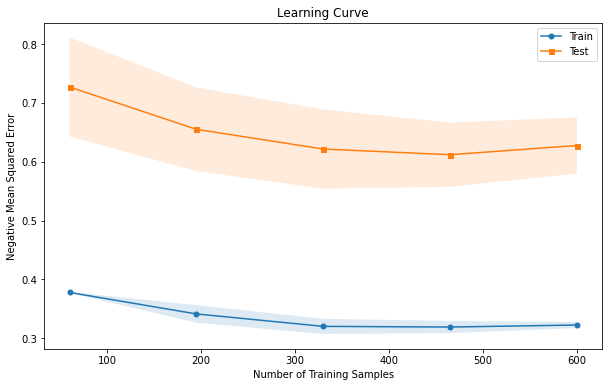

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model, X=X_train_encoded, y=y_train, cv=5, scoring='neg_mean_squared_error')

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Train', marker='o', markersize=5)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Test', marker='s', markersize=5)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
plt.xlabel('Number of Training Samples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='upper right')
plt.title('Learning Curve')
plt.show()